In [1]:

import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import time as tm
import scanpy as sc
import anndata
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch
from dataset import setup_seed,train_test_valid_loader_setup,get_accuracy #
from model import tre
from train import run_inference_for_epoch,get_evaluate_loss,lossplot
torch.set_default_tensor_type(torch.FloatTensor)
import pyro
from pyro.infer import SVI,  JitTraceEnum_ELBO, Trace_ELBO, config_enumerate
from pyro.optim import Adam, ExponentialLR
from sklearn.metrics import accuracy_score, f1_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
input_path = "/home/yingwang/cl/benchmark/trevi/data"
output_path = "/home/yingwang/cl/benchmark/trevi/output"

In [3]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

In [4]:
#Set the missing initial value
setup_seed(233)
learning_rate =3e-4#1e-3
decay_rate = 0.97
enum_discrete = "parallel"
beta_1 = 0.99
cuda = True
float64 = False
config_enum = "parallel"
validation_fold = 0.1
batch_size = 60
test_size=0.4
unsuptrain_size=0.3
valid_size=0.1
sup_num, unsup_num = 0, 0

In [5]:
#Set the input path
datafile = pd.read_csv("{}/{}".format(input_path,"rnacount_10xpbmc.csv"),index_col=0)
label_file=pd.read_csv("{}/{}".format(input_path,"label_10xpbmc.csv"),index_col=0)
acc_p = pd.read_csv("{}/{}".format(input_path,"accp_10xpbmc.csv"),index_col=0)
mask = pd.read_csv("{}/{}".format(input_path,"tf_gene.csv"),index_col=0)
tfname = pd.read_csv("{}/{}".format(input_path,"tf_gene.csv"),index_col=0)

In [6]:
#Input data preprocess
classnum=len(np.unique(label_file))
savebarcode=pd.DataFrame(datafile.index)
barcode=savebarcode.index.tolist()
acc_p=acc_p.T
acc_p=acc_p.fillna(0)
datafile=datafile.fillna(0)
label_file=label_file.values
datafile=datafile.values
acc_p=acc_p.values
acc_p=acc_p+0.01
acc_p=acc_p.astype(np.float32)
datafile=datafile.astype(np.float32)
mask=mask.values

In [7]:
#Setup dataloader

data_loaders = {'sup':None, 'unsup':None, 'valid':None ,'test':None}
data_loaders['sup'],data_loaders['valid'],data_loaders['unsup'],data_loaders['test'] = train_test_valid_loader_setup(datafile,label_file,acc_p,barcode,classnum,cuda,float64,batch_size,test_size, unsuptrain_size,valid_size)

In [8]:
#Setup model
z_dim=mask.shape[1]
output_size_rna = len(np.unique(label_file))
input_size_rna = datafile.shape[1]
mask_size = mask.shape[0]*mask.shape[1]
aux_loss=True

scc = tre(
    output_size = output_size_rna,
    input_size = input_size_rna,
    z_dim = z_dim,
    hidden_layers = [30],
    use_cuda = cuda,
    config_enum = enum_discrete,
    mask = mask,
    mask_size =mask_size,
    aux_loss_multiplier = 46,
    )
    
# setup the optimizer
adam_params = {'lr': learning_rate, 'betas':(beta_1, 0.999), 'weight_decay': 0.001}#0.001
#optimizer = Adam(adam_params)
optimizer = torch.optim.Adam
decayRate = decay_rate
scheduler = ExponentialLR({'optimizer': optimizer, 'optim_args': adam_params, 'gamma': decayRate})

pyro.clear_param_store()
# set up the loss(es) for inference, wrapping the guide in config_enumerate builds the loss as a sum
# by enumerating each class label form the sampled discrete categorical distribution in the model
guide = config_enumerate(scc.guide, enum_discrete, expand = True)
Elbo = JitTraceEnum_ELBO 
elbo = Elbo(max_plate_nesting = 1, strict_enumeration_warning = False)
loss_basic = SVI(scc.model, guide, scheduler, loss = elbo)


In [9]:
# build a list of all losses considered
losses = [loss_basic]
if aux_loss:
            elbo =  Trace_ELBO()
            loss_aux = SVI(scc.model_classify, scc.guide_classify, scheduler, loss = elbo)
            losses.append(loss_aux)
            loss_aux1 = SVI(scc.model_classify1, scc.guide_classify1, scheduler, loss = elbo)
            losses.append(loss_aux1)
    
num_epochs =100
decay_epochs =20
sup_num = data_loaders['sup'].dataset.data.shape[0]#细胞数
unsup_num = data_loaders['unsup'].dataset.data.shape[0]
valid_num=data_loaders['valid'].dataset.data.shape[0]
test_num=data_loaders['test'].dataset.data.shape[0]


In [10]:

try:
        # seen across epochs over the supervised training set
        # and the corresponding testing set and the state of the networks
        best_valid_acc = 0.0
        best_valid_f1m = 0.0

        asso_valid_f1m = 0.0
        asso_valid_f1w = 0.0
        asso_valid_pre = 0.0
        asso_valid_rec = 0.0
        asso_valid_mcc = 0.0
        
        asso_unsup_acc = 0.0
        asso_unsup_f1m = 0.0
        asso_unsup_f1w = 0.0
        asso_unsup_pre = 0.0
        asso_unsup_rec = 0.0
        asso_unsup_mcc = 0.0
        
        tr_start=tm.time()
        unsupplosses=[]
        supplosses=[]
        vallosses=[]
        # run inference for a certain number of epochs
        for i in range(0, num_epochs):
            ep_tr_start = tm.time()

            # get the losses for an epoch
            
            epoch_losses_sup, epoch_losses_unsup = run_inference_for_epoch(
                data_loaders['sup'], data_loaders['unsup'], losses, cuda
            )
            epoch_losses_valid = get_evaluate_loss(
               data_loaders['valid'], losses, cuda
            ) 
            # compute average epoch losses i.e. losses per example
            avg_epoch_losses_sup = map(lambda v: v / sup_num, epoch_losses_sup)
            avg_epoch_losses_unsup = map(lambda v: v / unsup_num, epoch_losses_unsup) if unsup_num > 0 else [0] * len(epoch_losses_unsup)
            
            avg_epoch_losses_sup = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_sup)
            avg_epoch_losses_unsup = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_unsup)

            
            avg_epoch_losses_valid = map(lambda v: v /valid_num, epoch_losses_valid) if valid_num > 0 else [0] * len(epoch_losses_valid)
            avg_epoch_losses_valid = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_valid)   
            # store the loss
            str_loss_sup = " ".join(map(str, avg_epoch_losses_sup))
            supplosses.append(str_loss_sup)

            str_loss_unsup = " ".join(map(str, avg_epoch_losses_unsup))
            unsupplosses.append(str_loss_unsup)
            
            str_loss_valid = " ".join(map(str, avg_epoch_losses_valid))
            vallosses.append(str_loss_valid) 
            str_print = "{} epoch: avg losses {}".format(
                i+1, "{} {} {}".format(str_loss_sup, str_loss_unsup,str_loss_valid)
            )

            validation_accuracy, validation_f1_macro, validation_f1_weighted, validation_precision, validation_recall, validation_mcc,ARI, NMI = get_accuracy(
                data_loaders["valid"], scc.classifier
            )

            str_print += " validation accuracy {:.4f}".format(validation_accuracy)
            str_print += " F1 {:.4f}(macro) {:.4f}(weighted)".format(validation_f1_macro, validation_f1_weighted)
            str_print += " precision {:.4f} recall {:.4f}".format(validation_precision, validation_recall)
            str_print += " mcc {:.4f}".format(validation_mcc)
            str_print += " ARI {:.4f} NMI {:.4f}".format(ARI, NMI)  

            
            unsup_accuracy, unsup_f1_macro, unsup_f1_weighted, unsup_precision, unsup_recall, unsup_mcc,ARI, NMI = get_accuracy(
                    data_loaders['unsup'], scc.classifier)
                           
            
            ep_tr_time = tm.time() - ep_tr_start
            str_print += " elapsed {:.4f} seconds".format(ep_tr_time)
            print(str_print)
            # update the best validation accuracy and the state of the parent 
            # module (including the networks)
            if best_valid_acc <= validation_accuracy:
                do_update = False
                if best_valid_acc < validation_accuracy:
                    do_update = True
                elif best_valid_f1m < validation_f1_macro:
                    do_update = True

                if do_update:
                    best_valid_acc = validation_accuracy
                    best_valid_f1m = validation_f1_macro
                    
                    asso_valid_f1m = validation_f1_macro
                    asso_valid_f1w = validation_f1_weighted
                    asso_valid_pre = validation_precision
                    asso_valid_rec = validation_recall
                    asso_valid_mcc = validation_mcc

                    
                    asso_unsup_acc = unsup_accuracy
                    asso_unsup_f1m = unsup_f1_macro
                    asso_unsup_f1w = unsup_f1_weighted
                    asso_unsup_pre = unsup_precision
                    asso_unsup_rec = unsup_recall
                    asso_unsup_mcc = unsup_mcc

            if i%decay_epochs == 0:
                scheduler.step() 


        tr_time=tm.time()-tr_start
        print('running time: {} secs'.format(tr_time))

        print(
            "best validation accuracy {:.4f}".format(
                best_valid_acc
            ),
        )
        print(
                "unsup accuracy: {:.4f} \nF1: {:.4f}(macro) {:.4f}(weighted) \nprecision {:.4f} recall {:.4f} \nmcc {:.4f}".format(
                    asso_unsup_acc, asso_unsup_f1m, asso_unsup_f1w, asso_unsup_pre, asso_unsup_rec, asso_unsup_mcc
                ),
            )

finally:print("train done") 


1 epoch: avg losses 24434.2888 5367.4864 15876.6489 15866.4287 4428.8169 6501.6919 13742.9404 3801.3895 5924.4990 validation accuracy 0.3972 F1 0.0682(macro) 0.2912(weighted) precision 0.0572 recall 0.1047 mcc 0.3386 ARI 0.2136 NMI 0.3881 elapsed 31.3191 seconds
2 epoch: avg losses 13923.7368 4196.3411 6510.9441 11477.2678 3756.1403 6234.8195 9837.8071 3411.0072 5696.1394 validation accuracy 0.3806 F1 0.0776(macro) 0.3034(weighted) precision 0.0724 recall 0.1078 mcc 0.2953 ARI 0.2798 NMI 0.4056 elapsed 19.0167 seconds
train done


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py(19): scatter_map
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py(23): scatter_map
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py(36): scatter
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/parallel/scatter_gather.py(44): scatter_kwargs
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py(175): scatter
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py(158): forward
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/modules/module.py(1118): _slow_forward
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/modules/module.py(1130): _call_impl
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/modules/container.py(139): forward
/home/yingwang/cl/benchmark/trevi copy/custom_mlp.py(220): forward
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/modules/module.py(1118): _slow_forward
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/modules/module.py(1130): _call_impl
/home/yingwang/cl/benchmark/trevi copy/model.py(166): model
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/poutine/messenger.py(12): _context_wrap
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/poutine/messenger.py(12): _context_wrap
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/poutine/trace_messenger.py(174): __call__
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/poutine/trace_messenger.py(198): get_trace
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/infer/enum.py(55): get_importance_trace
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/infer/traceenum_elbo.py(339): _get_trace
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/infer/traceenum_elbo.py(392): _get_traces
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/infer/traceenum_elbo.py(551): differentiable_loss
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/poutine/messenger.py(12): _context_wrap
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/ops/jit.py(98): compiled
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/jit/_trace.py(795): trace
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/ops/jit.py(107): __call__
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/infer/traceenum_elbo.py(559): differentiable_loss
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/infer/traceenum_elbo.py(562): loss_and_grads
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/infer/svi.py(145): step
/home/yingwang/cl/benchmark/trevi copy/train.py(72): run_inference_for_epoch
/tmp/ipykernel_2151391/1962524812.py(30): <module>
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/interactiveshell.py(3457): run_code
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/interactiveshell.py(3377): run_ast_nodes
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/interactiveshell.py(3185): run_cell_async
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/interactiveshell.py(2960): _run_cell
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/interactiveshell.py(2914): run_cell
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/zmqshell.py(533): run_cell
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/ipkernel.py(353): do_execute
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/kernelbase.py(648): execute_request
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/kernelbase.py(353): dispatch_shell
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/kernelbase.py(446): process_one
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/kernelbase.py(457): dispatch_queue
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/asyncio/events.py(81): _run
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/asyncio/base_events.py(1859): _run_once
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/asyncio/base_events.py(570): run_forever
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/tornado/platform/asyncio.py(215): start
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/kernelapp.py(677): start
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/traitlets/config/application.py(976): launch_instance
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel_launcher.py(16): <module>
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/runpy.py(87): _run_code
/home/yingwang/miniconda3/envs/tfvae/lib/python3.8/runpy.py(194): _run_module_as_main
RuntimeError: KeyboardInterrupt: 

At:
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/parameter.py(10): __instancecheck__
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/_utils.py(550): _handle_complex
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/parallel/comm.py(186): scatter
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/torch/nn/parallel/_functions.py(96): forward
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/ops/jit.py(120): __call__
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/infer/traceenum_elbo.py(559): differentiable_loss
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/infer/traceenum_elbo.py(562): loss_and_grads
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/pyro/infer/svi.py(145): step
  /home/yingwang/cl/benchmark/trevi copy/train.py(72): run_inference_for_epoch
  /tmp/ipykernel_2151391/1962524812.py(30): <module>
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/interactiveshell.py(3457): run_code
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/interactiveshell.py(3377): run_ast_nodes
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/interactiveshell.py(3185): run_cell_async
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/interactiveshell.py(2960): _run_cell
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/IPython/core/interactiveshell.py(2914): run_cell
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/zmqshell.py(533): run_cell
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/ipkernel.py(353): do_execute
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/kernelbase.py(648): execute_request
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/kernelbase.py(353): dispatch_shell
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/kernelbase.py(446): process_one
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/kernelbase.py(457): dispatch_queue
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/asyncio/events.py(81): _run
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/asyncio/base_events.py(1859): _run_once
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/asyncio/base_events.py(570): run_forever
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/tornado/platform/asyncio.py(215): start
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel/kernelapp.py(677): start
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/traitlets/config/application.py(976): launch_instance
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/site-packages/ipykernel_launcher.py(16): <module>
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/runpy.py(87): _run_code
  /home/yingwang/miniconda3/envs/tfvae/lib/python3.8/runpy.py(194): _run_module_as_main



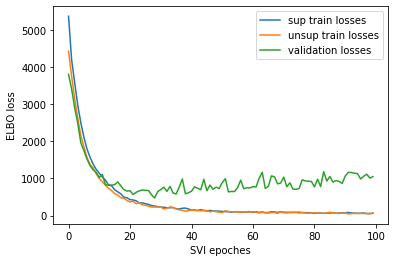

In [ ]:
lossplot(supplosses,unsupplosses,vallosses)
torch.save(scc.state_dict(), "%s/trevi9.14.pkl" % output_path)
output_size_rna = len(np.unique(label_file))
input_size_rna = datafile.shape[1]


In [11]:

scc = tre(
    output_size = output_size_rna,
    input_size = input_size_rna,
    z_dim = z_dim,
    hidden_layers = [30],
    use_cuda = cuda,
    config_enum = enum_discrete,
    mask = mask,
    mask_size =mask_size,
    aux_loss_multiplier = 46,
    )
scc.load_state_dict(torch.load("%s/trevi9.14.pkl" % output_path))
# predict
predictions, scores, actuals, zs, tf ,theta ,xss,barcodes= [], [], [], [], [],[],[],[]

# use the appropriate data loader
for (xs, ys,acc_p,barcode) in data_loaders['test']:
        # use classification function to compute all predictions for each batch
        yhats, yscores = scc.classifier_with_probability(xs)
        scores.append(yscores)

        _, yhats = torch.topk(yhats, 1)
        predictions.append(yhats.cpu().detach().numpy())

        _, ys = torch.topk(ys, 1)
        actuals.append(ys.cpu().detach().numpy())

        z=scc.latent_embedding(xs)
        zs.append(z.cpu().detach().numpy())

        tfs=abs(scc.predicted_tf(xs))
        tf.append(tfs.cpu().detach().numpy())

        xss.append(xs.cpu().detach().numpy())
        barcodes.append(barcode.cpu().detach().numpy())


predictions = np.concatenate(predictions, 0)
scores = torch.cat(scores, dim=0).cpu().detach().numpy()
actuals = np.concatenate(actuals, 0)
zs = np.concatenate(zs, 0)
tf = np.concatenate(tf, 0)
xss= np.concatenate(xss, 0)
barcodes= np.concatenate(barcodes, 0)

temp=np.array(torch.tensor(actuals.reshape(-1,1))).astype(str)
dict={'0':'CD14 Mono', '1': 'CD16 Mono', '2': 'CD4 Naive', '3': 'CD4 TCM', '4': 'CD4 TEM', '5':'CD8 Naive', '6':'CD8 TEM_1', '7': 'CD8 TEM_2', '8':'HSPC', '9': 'Intermediate B', '10': 'MAIT', '11': 'Memory B', '12':'NK', '13': 'Naive B', '14': 'Plasma','15': 'Treg', '16': 'cDC', '17': 'gdT', '18':'pDC'}
temp1= np.vectorize(dict.get)(temp)
temppre=np.array(torch.tensor(predictions.reshape(-1,1))).astype(str)
dict={'0':'CD14 Mono', '1': 'CD16 Mono', '2': 'CD4 Naive', '3': 'CD4 TCM', '4': 'CD4 TEM', '5':'CD8 Naive', '6':'CD8 TEM_1', '7': 'CD8 TEM_2', '8':'HSPC', '9': 'Intermediate B', '10': 'MAIT', '11': 'Memory B', '12':'NK', '13': 'Naive B', '14': 'Plasma','15': 'Treg', '16': 'cDC', '17': 'gdT', '18':'pDC'}
temppre1= np.vectorize(dict.get)(temppre)

test_accuracy, test_f1_macro, test_f1_weighted, test_precision, test_recall, test_mcc,ARI, NMI = get_accuracy(
                    data_loaders["test"], scc.classifier
                )
str_print1 = " test accuracy {:.4f}".format(test_accuracy)
str_print1 += " F1 {:.4f}(macro) {:.4f}(weighted)".format(test_f1_macro, test_f1_weighted)
str_print1 += " precision {:.4f} recall {:.4f}".format(test_precision, test_recall)
str_print1 += " mcc {:.4f}".format(test_mcc)            
str_print1 += " ARI {:.4f} NMI {:.4f}".format(ARI, NMI)  
print("accuracy:{:.4f}, f1_macro:{:.4f}, f1_weighted:{:.4f},ARI:{:.4f}, NMI:{:.4f}".format(test_accuracy,test_f1_macro,test_f1_weighted ,ARI,NMI))


accuracy:0.9005, f1_macro:0.8539, f1_weighted:0.8999,ARI:0.8640, NMI:0.8291


... storing 'cell_type' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


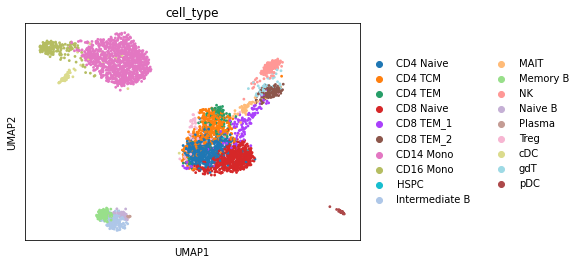

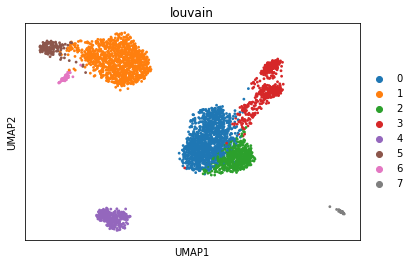

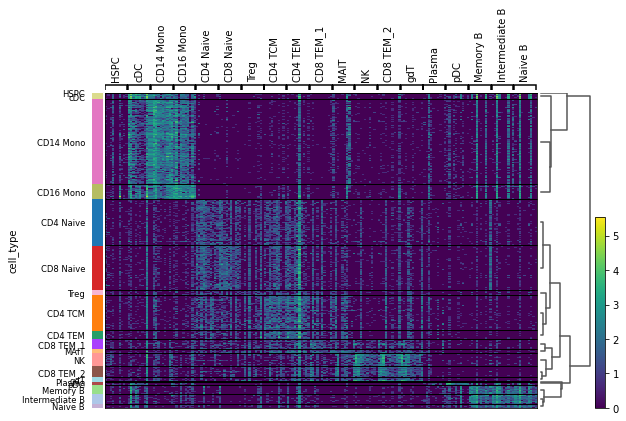

In [12]:

# visulization
prior_adata = anndata.AnnData(X=xss)
prior_adata.obsm["X_multi_vi"] = xss
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
originalcell=prior_adata.obs['louvain']
prior_adata.obs['cell_type'] = temp1
# origin cell label
sc.pl.umap(prior_adata, color=['cell_type'], show=False)
plt.savefig("%s/xs_actual_label.pdf" % output_path, format="pdf")
# origin cell label
sc.pl.umap(prior_adata, color=['louvain'], show=False)
plt.savefig("%s/xs_predict_labl.pdf" % output_path, format="pdf")
        
sc.tl.rank_genes_groups(prior_adata, 'cell_type', method="t-test")
sc.pl.rank_genes_groups_heatmap(prior_adata, n_genes=10, groupby='cell_type', show=False)
plt.savefig("%s/xs_heatmap.pdf" % output_path, format="pdf")
groundtruth=prior_adata.obs['cell_type']


In [13]:

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score

In [14]:
ARI1 = adjusted_rand_score(groundtruth.ravel(), originalcell.ravel())
NMI1 = normalized_mutual_info_score(groundtruth.ravel(), originalcell.ravel())

accuracy1 = accuracy_score(groundtruth.ravel(), originalcell.ravel())
f1_macro1 = f1_score(groundtruth.ravel(), originalcell.ravel(), average='macro')
f1_weighted1 = f1_score(groundtruth.ravel(), originalcell.ravel(), average='weighted')
print("xs accuracy:{:.4f}, f1_macro:{:.4f}, f1_weighted:{:.4f},ARI:{:.4f}, NMI:{:.4f}".format(accuracy1,f1_macro1  ,f1_weighted1 ,ARI1,NMI1))
   


xs accuracy:0.0000, f1_macro:0.0000, f1_weighted:0.0000,ARI:0.6521, NMI:0.7495


... storing 'cell_type' as categorical
... storing 'cell_type pre' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


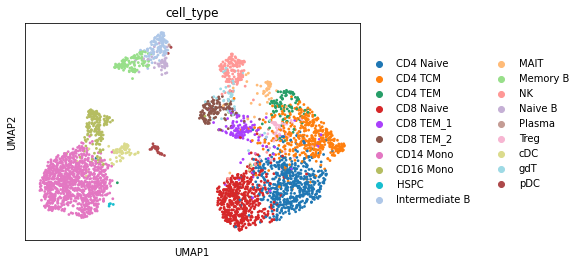

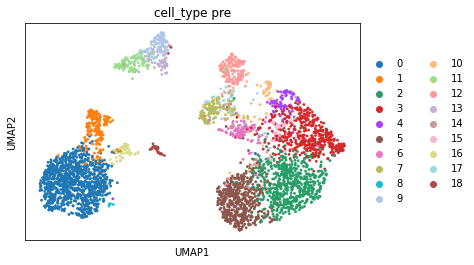

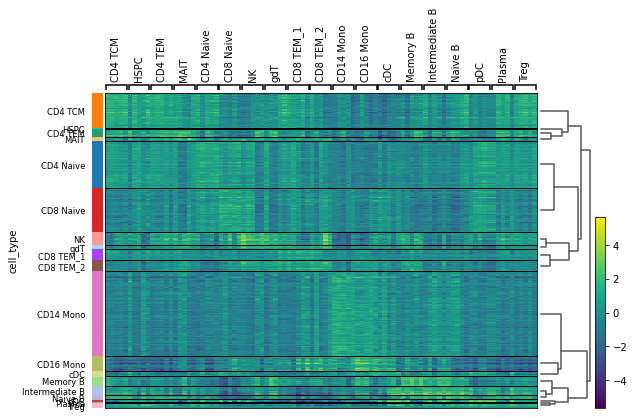

In [15]:
genename=pd.DataFrame(tfname.index)
tfname1=pd.DataFrame(tfname.columns)
prior_adata1 = anndata.AnnData(X=zs,var=tfname1)
prior_adata1.obsm["X_multi_vi"] = zs
sc.pp.neighbors(prior_adata1, use_rep="X_multi_vi", n_neighbors=20)
sc.tl.umap(prior_adata1, min_dist=0.3)

sc.tl.louvain(prior_adata1)
prior_adata1.obs['cell_type'] = temp1
# origin cell label
sc.pl.umap(prior_adata1, color=['cell_type'], show=False)

plt.savefig("%s/ztf_actual_labl.pdf" % output_path, format="pdf")
# plt.show()
prior_adata1.obs['cell_type pre'] = temppre
# origin cell label
sc.pl.umap(prior_adata1, color=['cell_type pre'], show=False)
plt.savefig("%s/ztf_predict_labl.pdf" % output_path, format="pdf")
prior_adata1.var.index=prior_adata1.var[0]
sc.tl.rank_genes_groups(prior_adata1, 'cell_type', method="t-test")
sc.pl.rank_genes_groups_heatmap(prior_adata1, n_genes=5, groupby='cell_type', show=False)
plt.savefig("%s/ztf_heatmap.pdf" % output_path, format="pdf")


In [16]:
ztf=pd.DataFrame(zs)
ztf.index=barcodes
ztf.columns=tfname1
ztf.to_csv("%s/ztf_embedding.csv" % output_path)
tfname = pd.read_csv("{}/{}".format(input_path,"tf_gene.csv"),index_col=0)
tfm=pd.DataFrame(tf)
tfm.index=barcodes
tfm['y']=actuals
cd14tf=pd.DataFrame(np.mean(tfm[tfm['y']==0],0))#cd14 mono pink
    
cd14tf=cd14tf.drop(index=["y"])
cd14tf=cd14tf.values
cd14tf=cd14tf.reshape(3000,98)
cd14tf=pd.DataFrame(cd14tf)
cd14tf.index=tfname.index
cd14tf.columns=tfname.columns
cd14tf=cd14tf.T
cd14tf.to_csv("%s/zgrn_cd14_mono.csv" % output_path)
e2f2=cd14tf[cd14tf.index=='E2F2']
res = e2f2.sort_values(by='E2F2', ascending=False,axis=1)

        


In [17]:
res

,AL592429.2,PIGL,SMC2,SEMA3A,HSD17B2,LINC01505,DGKH,HTR7,RYR3,MEF2C,...,PTX3,NFIA,LINC00278,RNF165,AL138767.1,ZSWIM6,BAMBI,PLS3,PLXNA4,NEDD4
E2F2,0.262028,0.258469,0.255203,0.241739,0.241302,0.240612,0.240185,0.239956,0.237533,0.233245,...,0.033952,0.033434,0.033415,0.033122,0.032696,0.031918,0.031123,0.030759,0.029709,0.02769
